In [1]:
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import pandas as pd
np.random.seed(100)

In [2]:
df = pd.read_csv('ratings.dat', sep='::', header=None, engine='python')
df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
df.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
df.shape

(1000209, 4)

In [4]:
all_user_cnt = len(df.user_id.unique())
all_user_cnt

6040

In [5]:
all_movies = set(df.movie_id.unique())
all_movie_cnt = len(all_movies)
all_movie_cnt

3706

## split data

In [6]:
X, y = df[['user_id', 'movie_id']].values, df['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/8, random_state=0)

In [7]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(875182, 2) (875182,) (125027, 2) (125027,)


In [8]:
movie_popularity = defaultdict(int)
for _, m_id in X_train:
    movie_popularity[m_id] += 1

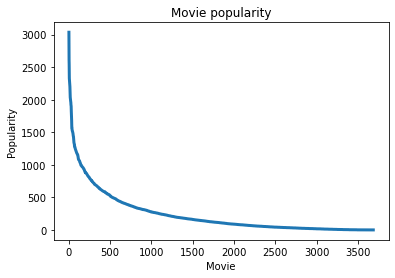

In [9]:
sorted_movie_popularity = sorted(movie_popularity.items(), key=lambda x: x[1], reverse=True)
plt.plot(list(map(lambda x: x[1], sorted_movie_popularity)), linewidth=3)
plt.title('Movie popularity')
plt.ylabel('Popularity')
plt.xlabel('Movie')
plt.show()

## Latent Factor Model

In [10]:
def get_user_movies(data):
    user_movies = defaultdict(set)
    for u_id, m_id in data:
        user_movies[u_id].add(m_id)
    return user_movies

In [11]:
user_movies_train = get_user_movies(X_train)
user_movies_test = get_user_movies(X_test)

In [14]:
class LatentFactorModel:
    def __init__(self, K, alpha, beta, ratio):
        self.K = K  # latent factor dimentions
        self.alpha = alpha  # learning rate
        self.beta = beta  # regularization
        self.ratio = ratio  # positive sample / negative sample, downsampling, most items are not iteracted with users
        self.P = {}
        self.Q = {}
        
    def init_model(self, user_movies):
        for u_id, u_movies in user_movies.items():
            if u_id not in self.P:
                self.P[u_id] = np.random.rand(self.K)
            for m_id in u_movies:
                if m_id not in self.Q:
                    self.Q[m_id] = np.random.rand(self.K)
                    
    def sample_data(self, u_id, u_movies, movie_popularity):
        all_movies = set(movie_popularity.keys())
        pos_movies = u_movies
        all_neg_movies = list(all_movies - pos_movies)
        neg_movies = np.random.choice(all_neg_movies, size=int(self.ratio * len(pos_movies)), replace=True, p=None)
        
        data = []
        for m_id in pos_movies:
            data.append((u_id, m_id, 1))
        for m_id in neg_movies:
            data.append((u_id, m_id, 0))
        np.random.shuffle(data)
        return data
    
    def calc_loss(self, user_movies, movie_popularity):
        loss = 0
        for u_id, u_movies in user_movies.items():
            data = self.sample_data(u_id, u_movies, movie_popularity)
            for u_id, m_id, rui in data:
                loss += np.square(rui - np.dot(self.P[u_id], self.Q[m_id])) + self.beta * np.sum(np.square(self.P[u_id]) + np.square(self.Q[m_id]))
        return loss / len(user_movies)
    
    def train(self, user_movies, movie_popularity, epoch):
        self.init_model(user_movies)
        alpha = self.alpha
        for t in range(epoch):
            for u_id, u_movies in tqdm(user_movies.items()):
                data = self.sample_data(u_id, u_movies, movie_popularity)
                for u_id, m_id, rui in data:
                    eui = rui - np.dot(self.P[u_id], self.Q[m_id])
                    self.P[u_id] += alpha * (eui * self.Q[m_id] - self.beta * self.P[u_id])
                    self.Q[m_id] += alpha * (eui * self.P[u_id] - self.beta * self.Q[m_id])
            alpha *= 0.9
            print('epoch:{}, lr:{}'.format(t, alpha))

    def recommend(self, u_id, user_movies):
        res = defaultdict(float)
        u_movies = user_movies[u_id]
        u_vec = self.P[u_id]
        for m_id in self.Q:
            if m_id not in u_movies:
                m_vec = self.Q[m_id]
                res[m_id] = np.dot(u_vec, m_vec)
        return list(map(lambda x: x[0], sorted(res.items(), key=lambda x: x[1], reverse=True)))

## evaluation

In [12]:
def calc_metrics(user_movies, user_movies_reco, all_movie_cnt, n=None):
    label_all, reco_all, hit = 0, 0, 0
    all_movies_reco = []
    for u_id in user_movies:
        label_movies = user_movies[u_id]
        reco_movies = user_movies_reco[u_id][:n] if n else user_movies_reco[u_id]
        all_movies_reco += reco_movies
        reco_movies = set(reco_movies)
        label_all += len(label_movies)
        reco_all += len(reco_movies)
        hit += len(label_movies & reco_movies)
    return {
        'precision': hit / reco_all,
        'recall': hit / label_all,
        'coverage': len(set(all_movies_reco)) / all_movie_cnt
    }

In [15]:
model = LatentFactorModel(K=100, alpha=0.02, beta=0.01, ratio=10)
model.train(user_movies_train, movie_popularity, 20)

user_movies_reco = {}
for u_id in user_movies_test:
    user_movies_reco[u_id] = model.recommend(u_id, user_movies_train)
    
calc_metrics(user_movies_test, user_movies_reco, all_movie_cnt, n=10)

100%|██████████| 6040/6040 [01:59<00:00, 50.41it/s] 


epoch:0, lr:0.018000000000000002


100%|██████████| 6040/6040 [02:01<00:00, 49.77it/s] 


epoch:1, lr:0.016200000000000003


100%|██████████| 6040/6040 [02:01<00:00, 49.78it/s] 


epoch:2, lr:0.014580000000000003


100%|██████████| 6040/6040 [02:01<00:00, 49.79it/s] 


epoch:3, lr:0.013122000000000003


100%|██████████| 6040/6040 [02:02<00:00, 49.39it/s] 


epoch:4, lr:0.011809800000000004


100%|██████████| 6040/6040 [01:59<00:00, 50.58it/s] 


epoch:5, lr:0.010628820000000004


100%|██████████| 6040/6040 [01:58<00:00, 50.93it/s] 


epoch:6, lr:0.009565938000000005


100%|██████████| 6040/6040 [02:02<00:00, 49.45it/s] 


epoch:7, lr:0.008609344200000004


100%|██████████| 6040/6040 [01:54<00:00, 52.82it/s] 


epoch:8, lr:0.007748409780000004


100%|██████████| 6040/6040 [01:53<00:00, 53.06it/s] 


epoch:9, lr:0.006973568802000004


100%|██████████| 6040/6040 [11:22:35<00:00,  6.78s/it]       


epoch:10, lr:0.006276211921800004


100%|██████████| 6040/6040 [01:41<00:00, 59.67it/s] 


epoch:11, lr:0.0056485907296200035


100%|██████████| 6040/6040 [01:54<00:00, 52.81it/s] 


epoch:12, lr:0.005083731656658003


100%|██████████| 6040/6040 [01:52<00:00, 53.74it/s] 


epoch:13, lr:0.004575358490992203


100%|██████████| 6040/6040 [01:45<00:00, 57.32it/s] 


epoch:14, lr:0.004117822641892983


100%|██████████| 6040/6040 [01:46<00:00, 56.98it/s] 


epoch:15, lr:0.003706040377703685


100%|██████████| 6040/6040 [02:11<00:00, 46.00it/s] 


epoch:16, lr:0.0033354363399333165


100%|██████████| 6040/6040 [01:59<00:00, 50.55it/s] 


epoch:17, lr:0.0030018927059399848


100%|██████████| 6040/6040 [02:00<00:00, 50.20it/s] 


epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [02:00<00:00, 49.95it/s] 


epoch:19, lr:0.002431533091811388


{'precision': 0.26579429904984164,
 'recall': 0.12753245299015412,
 'coverage': 0.18213707501349163}

## different sampling

In [16]:
ratio_list = [1.0, 2.0, 5.0, 10.0, 20.0]
metrics_ratio = {}

for ratio in ratio_list:
    model = LatentFactorModel(K=100, alpha=0.02, beta=0.01, ratio=ratio)
    model.train(user_movies_train, movie_popularity, 20)

    user_movies_reco = {}
    for u_id in user_movies_test:
        user_movies_reco[u_id] = model.recommend(u_id, user_movies_train)

    metrics_ratio[ratio] = calc_metrics(user_movies_test, user_movies_reco, all_movie_cnt, n=10)

pd.DataFrame(metrics_ratio)

100%|██████████| 6040/6040 [00:24<00:00, 250.72it/s]


epoch:0, lr:0.018000000000000002


100%|██████████| 6040/6040 [00:23<00:00, 253.00it/s]


epoch:1, lr:0.016200000000000003


100%|██████████| 6040/6040 [00:24<00:00, 246.92it/s]


epoch:2, lr:0.014580000000000003


100%|██████████| 6040/6040 [00:24<00:00, 248.37it/s]


epoch:3, lr:0.013122000000000003


100%|██████████| 6040/6040 [00:24<00:00, 248.73it/s]


epoch:4, lr:0.011809800000000004


100%|██████████| 6040/6040 [00:24<00:00, 248.23it/s]


epoch:5, lr:0.010628820000000004


100%|██████████| 6040/6040 [00:24<00:00, 244.67it/s]


epoch:6, lr:0.009565938000000005


100%|██████████| 6040/6040 [00:24<00:00, 246.67it/s]


epoch:7, lr:0.008609344200000004


100%|██████████| 6040/6040 [00:24<00:00, 248.48it/s]


epoch:8, lr:0.007748409780000004


100%|██████████| 6040/6040 [00:24<00:00, 247.03it/s]


epoch:9, lr:0.006973568802000004


100%|██████████| 6040/6040 [00:24<00:00, 245.98it/s]


epoch:10, lr:0.006276211921800004


100%|██████████| 6040/6040 [00:24<00:00, 244.75it/s]


epoch:11, lr:0.0056485907296200035


100%|██████████| 6040/6040 [00:24<00:00, 248.40it/s]


epoch:12, lr:0.005083731656658003


100%|██████████| 6040/6040 [00:24<00:00, 245.26it/s]


epoch:13, lr:0.004575358490992203


100%|██████████| 6040/6040 [00:24<00:00, 245.79it/s]


epoch:14, lr:0.004117822641892983


100%|██████████| 6040/6040 [00:24<00:00, 242.84it/s]


epoch:15, lr:0.003706040377703685


100%|██████████| 6040/6040 [00:24<00:00, 244.98it/s]


epoch:16, lr:0.0033354363399333165


100%|██████████| 6040/6040 [00:24<00:00, 242.04it/s]


epoch:17, lr:0.0030018927059399848


100%|██████████| 6040/6040 [00:24<00:00, 243.93it/s]


epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [00:25<00:00, 240.93it/s]


epoch:19, lr:0.002431533091811388


100%|██████████| 6040/6040 [00:34<00:00, 174.31it/s]


epoch:0, lr:0.018000000000000002


100%|██████████| 6040/6040 [00:35<00:00, 171.00it/s]


epoch:1, lr:0.016200000000000003


100%|██████████| 6040/6040 [00:35<00:00, 172.24it/s]


epoch:2, lr:0.014580000000000003


100%|██████████| 6040/6040 [00:35<00:00, 169.85it/s]


epoch:3, lr:0.013122000000000003


100%|██████████| 6040/6040 [00:35<00:00, 169.96it/s]


epoch:4, lr:0.011809800000000004


100%|██████████| 6040/6040 [00:35<00:00, 171.56it/s]


epoch:5, lr:0.010628820000000004


100%|██████████| 6040/6040 [00:35<00:00, 169.62it/s]


epoch:6, lr:0.009565938000000005


100%|██████████| 6040/6040 [00:36<00:00, 167.26it/s]


epoch:7, lr:0.008609344200000004


100%|██████████| 6040/6040 [00:35<00:00, 168.85it/s]


epoch:8, lr:0.007748409780000004


100%|██████████| 6040/6040 [00:35<00:00, 169.35it/s]


epoch:9, lr:0.006973568802000004


100%|██████████| 6040/6040 [00:35<00:00, 169.33it/s]


epoch:10, lr:0.006276211921800004


100%|██████████| 6040/6040 [00:35<00:00, 168.36it/s]


epoch:11, lr:0.0056485907296200035


100%|██████████| 6040/6040 [00:35<00:00, 169.07it/s]


epoch:12, lr:0.005083731656658003


100%|██████████| 6040/6040 [00:35<00:00, 169.07it/s]


epoch:13, lr:0.004575358490992203


100%|██████████| 6040/6040 [00:35<00:00, 167.98it/s]


epoch:14, lr:0.004117822641892983


100%|██████████| 6040/6040 [00:35<00:00, 169.17it/s]


epoch:15, lr:0.003706040377703685


100%|██████████| 6040/6040 [00:36<00:00, 166.96it/s]


epoch:16, lr:0.0033354363399333165


100%|██████████| 6040/6040 [00:36<00:00, 166.98it/s]


epoch:17, lr:0.0030018927059399848


100%|██████████| 6040/6040 [00:36<00:00, 166.80it/s]


epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [00:36<00:00, 165.63it/s]


epoch:19, lr:0.002431533091811388


100%|██████████| 6040/6040 [01:09<00:00, 86.85it/s] 


epoch:0, lr:0.018000000000000002


100%|██████████| 6040/6040 [01:09<00:00, 86.40it/s] 


epoch:1, lr:0.016200000000000003


100%|██████████| 6040/6040 [01:09<00:00, 86.83it/s] 


epoch:2, lr:0.014580000000000003


100%|██████████| 6040/6040 [01:12<00:00, 83.57it/s] 


epoch:3, lr:0.013122000000000003


100%|██████████| 6040/6040 [01:13<00:00, 82.59it/s] 


epoch:4, lr:0.011809800000000004


100%|██████████| 6040/6040 [01:12<00:00, 83.58it/s] 


epoch:5, lr:0.010628820000000004


100%|██████████| 6040/6040 [01:10<00:00, 85.83it/s] 


epoch:6, lr:0.009565938000000005


100%|██████████| 6040/6040 [01:12<00:00, 83.87it/s] 


epoch:7, lr:0.008609344200000004


100%|██████████| 6040/6040 [01:09<00:00, 86.97it/s] 


epoch:8, lr:0.007748409780000004


100%|██████████| 6040/6040 [01:03<00:00, 94.39it/s] 


epoch:9, lr:0.006973568802000004


100%|██████████| 6040/6040 [01:03<00:00, 95.18it/s] 


epoch:10, lr:0.006276211921800004


100%|██████████| 6040/6040 [01:02<00:00, 97.17it/s] 


epoch:11, lr:0.0056485907296200035


100%|██████████| 6040/6040 [01:02<00:00, 97.25it/s] 


epoch:12, lr:0.005083731656658003


100%|██████████| 6040/6040 [01:02<00:00, 97.21it/s] 


epoch:13, lr:0.004575358490992203


100%|██████████| 6040/6040 [01:01<00:00, 97.55it/s] 


epoch:14, lr:0.004117822641892983


100%|██████████| 6040/6040 [01:01<00:00, 97.51it/s] 


epoch:15, lr:0.003706040377703685


100%|██████████| 6040/6040 [01:02<00:00, 96.96it/s] 


epoch:16, lr:0.0033354363399333165


100%|██████████| 6040/6040 [01:02<00:00, 96.06it/s] 


epoch:17, lr:0.0030018927059399848


100%|██████████| 6040/6040 [01:02<00:00, 97.35it/s] 


epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [01:02<00:00, 97.38it/s] 


epoch:19, lr:0.002431533091811388


100%|██████████| 6040/6040 [01:50<00:00, 54.52it/s] 


epoch:0, lr:0.018000000000000002


100%|██████████| 6040/6040 [01:51<00:00, 54.26it/s] 


epoch:1, lr:0.016200000000000003


100%|██████████| 6040/6040 [01:52<00:00, 53.80it/s] 


epoch:2, lr:0.014580000000000003


100%|██████████| 6040/6040 [01:53<00:00, 53.15it/s] 


epoch:3, lr:0.013122000000000003


100%|██████████| 6040/6040 [01:53<00:00, 53.12it/s] 


epoch:4, lr:0.011809800000000004


100%|██████████| 6040/6040 [01:51<00:00, 53.93it/s] 


epoch:5, lr:0.010628820000000004


100%|██████████| 6040/6040 [01:51<00:00, 54.28it/s] 


epoch:6, lr:0.009565938000000005


100%|██████████| 6040/6040 [01:50<00:00, 54.62it/s] 


epoch:7, lr:0.008609344200000004


100%|██████████| 6040/6040 [01:50<00:00, 54.62it/s] 


epoch:8, lr:0.007748409780000004


100%|██████████| 6040/6040 [01:50<00:00, 54.59it/s] 


epoch:9, lr:0.006973568802000004


100%|██████████| 6040/6040 [01:50<00:00, 54.78it/s] 


epoch:10, lr:0.006276211921800004


100%|██████████| 6040/6040 [01:50<00:00, 54.71it/s] 


epoch:11, lr:0.0056485907296200035


100%|██████████| 6040/6040 [01:51<00:00, 54.36it/s] 


epoch:12, lr:0.005083731656658003


100%|██████████| 6040/6040 [01:50<00:00, 54.69it/s] 


epoch:13, lr:0.004575358490992203


100%|██████████| 6040/6040 [01:51<00:00, 54.31it/s] 


epoch:14, lr:0.004117822641892983


100%|██████████| 6040/6040 [01:51<00:00, 54.34it/s] 


epoch:15, lr:0.003706040377703685


100%|██████████| 6040/6040 [01:51<00:00, 54.36it/s] 


epoch:16, lr:0.0033354363399333165


100%|██████████| 6040/6040 [01:52<00:00, 53.93it/s] 


epoch:17, lr:0.0030018927059399848


100%|██████████| 6040/6040 [01:52<00:00, 53.85it/s] 


epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [01:52<00:00, 53.61it/s] 


epoch:19, lr:0.002431533091811388


100%|██████████| 6040/6040 [03:31<00:00, 28.56it/s] 


epoch:0, lr:0.018000000000000002


100%|██████████| 6040/6040 [03:30<00:00, 28.66it/s] 


epoch:1, lr:0.016200000000000003


100%|██████████| 6040/6040 [03:30<00:00, 28.72it/s] 


epoch:2, lr:0.014580000000000003


100%|██████████| 6040/6040 [03:30<00:00, 28.65it/s] 


epoch:3, lr:0.013122000000000003


100%|██████████| 6040/6040 [03:31<00:00, 28.59it/s] 


epoch:4, lr:0.011809800000000004


100%|██████████| 6040/6040 [03:30<00:00, 28.66it/s] 


epoch:5, lr:0.010628820000000004


100%|██████████| 6040/6040 [03:30<00:00, 28.75it/s] 


epoch:6, lr:0.009565938000000005


100%|██████████| 6040/6040 [03:35<00:00, 27.99it/s] 


epoch:7, lr:0.008609344200000004


100%|██████████| 6040/6040 [03:32<00:00, 28.40it/s] 


epoch:8, lr:0.007748409780000004


100%|██████████| 6040/6040 [03:31<00:00, 28.50it/s] 


epoch:9, lr:0.006973568802000004


100%|██████████| 6040/6040 [03:31<00:00, 28.55it/s] 


epoch:10, lr:0.006276211921800004


100%|██████████| 6040/6040 [03:32<00:00, 28.39it/s] 


epoch:11, lr:0.0056485907296200035


100%|██████████| 6040/6040 [03:31<00:00, 28.51it/s] 


epoch:12, lr:0.005083731656658003


100%|██████████| 6040/6040 [03:32<00:00, 28.43it/s] 


epoch:13, lr:0.004575358490992203


100%|██████████| 6040/6040 [03:32<00:00, 28.42it/s] 


epoch:14, lr:0.004117822641892983


100%|██████████| 6040/6040 [03:33<00:00, 28.35it/s] 


epoch:15, lr:0.003706040377703685


100%|██████████| 6040/6040 [03:38<00:00, 27.68it/s] 


epoch:16, lr:0.0033354363399333165


100%|██████████| 6040/6040 [03:34<00:00, 28.20it/s] 


epoch:17, lr:0.0030018927059399848


100%|██████████| 6040/6040 [03:32<00:00, 28.41it/s] 


epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [03:32<00:00, 28.43it/s] 


epoch:19, lr:0.002431533091811388


,1.0,2.0,5.0,10.0,20.0
precision,0.178396,0.224854,0.257360,0.264327,0.252559
recall,0.085598,0.107889,0.123485,0.126829,0.121182
coverage,0.877226,0.424717,0.253103,0.180248,0.118726


## different epochs

In [17]:
epoch_list = [10, 20, 30, 40, 50]
metrics_epoch = {}

for epoch in epoch_list:
    model = LatentFactorModel(K=100, alpha=0.02, beta=0.01, ratio=10)
    model.train(user_movies_train, movie_popularity, epoch)

    user_movies_reco = {}
    for u_id in user_movies_test:
        user_movies_reco[u_id] = model.recommend(u_id, user_movies_train)

    metrics_epoch[epoch] = calc_metrics(user_movies_test, user_movies_reco, all_movie_cnt, n=10)

pd.DataFrame(metrics_epoch)

100%|██████████| 6040/6040 [01:55<00:00, 52.48it/s] 


epoch:0, lr:0.018000000000000002


100%|██████████| 6040/6040 [01:52<00:00, 53.49it/s] 


epoch:1, lr:0.016200000000000003


100%|██████████| 6040/6040 [01:53<00:00, 53.04it/s] 


epoch:2, lr:0.014580000000000003


100%|██████████| 6040/6040 [01:53<00:00, 53.31it/s] 


epoch:3, lr:0.013122000000000003


100%|██████████| 6040/6040 [01:53<00:00, 53.21it/s] 


epoch:4, lr:0.011809800000000004


100%|██████████| 6040/6040 [01:53<00:00, 53.15it/s] 


epoch:5, lr:0.010628820000000004


100%|██████████| 6040/6040 [01:53<00:00, 53.42it/s] 


epoch:6, lr:0.009565938000000005


100%|██████████| 6040/6040 [01:52<00:00, 53.60it/s] 


epoch:7, lr:0.008609344200000004


100%|██████████| 6040/6040 [01:52<00:00, 53.45it/s] 


epoch:8, lr:0.007748409780000004


100%|██████████| 6040/6040 [01:53<00:00, 53.40it/s] 


epoch:9, lr:0.006973568802000004


100%|██████████| 6040/6040 [01:53<00:00, 53.32it/s] 


epoch:0, lr:0.018000000000000002


100%|██████████| 6040/6040 [01:53<00:00, 52.99it/s] 


epoch:1, lr:0.016200000000000003


100%|██████████| 6040/6040 [01:53<00:00, 53.10it/s] 


epoch:2, lr:0.014580000000000003


100%|██████████| 6040/6040 [01:53<00:00, 53.32it/s] 


epoch:3, lr:0.013122000000000003


100%|██████████| 6040/6040 [01:53<00:00, 53.18it/s] 


epoch:4, lr:0.011809800000000004


100%|██████████| 6040/6040 [01:53<00:00, 53.18it/s] 


epoch:5, lr:0.010628820000000004


100%|██████████| 6040/6040 [01:54<00:00, 52.94it/s] 


epoch:6, lr:0.009565938000000005


100%|██████████| 6040/6040 [01:53<00:00, 53.26it/s] 


epoch:7, lr:0.008609344200000004


100%|██████████| 6040/6040 [01:55<00:00, 52.35it/s] 


epoch:8, lr:0.007748409780000004


100%|██████████| 6040/6040 [01:55<00:00, 52.16it/s] 


epoch:9, lr:0.006973568802000004


100%|██████████| 6040/6040 [01:54<00:00, 52.80it/s] 


epoch:10, lr:0.006276211921800004


100%|██████████| 6040/6040 [01:56<00:00, 52.02it/s] 


epoch:11, lr:0.0056485907296200035


100%|██████████| 6040/6040 [01:54<00:00, 52.56it/s] 


epoch:12, lr:0.005083731656658003


100%|██████████| 6040/6040 [01:54<00:00, 52.72it/s] 


epoch:13, lr:0.004575358490992203


100%|██████████| 6040/6040 [01:55<00:00, 52.51it/s] 


epoch:14, lr:0.004117822641892983


100%|██████████| 6040/6040 [01:54<00:00, 52.72it/s] 


epoch:15, lr:0.003706040377703685


100%|██████████| 6040/6040 [01:53<00:00, 53.15it/s] 


epoch:16, lr:0.0033354363399333165


100%|██████████| 6040/6040 [01:54<00:00, 52.78it/s] 


epoch:17, lr:0.0030018927059399848


100%|██████████| 6040/6040 [01:54<00:00, 52.84it/s] 


epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [01:54<00:00, 52.68it/s] 


epoch:19, lr:0.002431533091811388


100%|██████████| 6040/6040 [01:54<00:00, 52.61it/s] 


epoch:0, lr:0.018000000000000002


100%|██████████| 6040/6040 [01:53<00:00, 53.00it/s] 


epoch:1, lr:0.016200000000000003


100%|██████████| 6040/6040 [01:53<00:00, 53.03it/s] 


epoch:2, lr:0.014580000000000003


100%|██████████| 6040/6040 [01:54<00:00, 52.94it/s] 


epoch:3, lr:0.013122000000000003


100%|██████████| 6040/6040 [01:54<00:00, 52.52it/s] 


epoch:4, lr:0.011809800000000004


100%|██████████| 6040/6040 [01:53<00:00, 53.05it/s] 


epoch:5, lr:0.010628820000000004


100%|██████████| 6040/6040 [01:54<00:00, 52.62it/s] 


epoch:6, lr:0.009565938000000005


100%|██████████| 6040/6040 [01:55<00:00, 52.37it/s] 


epoch:7, lr:0.008609344200000004


100%|██████████| 6040/6040 [01:55<00:00, 52.34it/s] 


epoch:8, lr:0.007748409780000004


100%|██████████| 6040/6040 [01:54<00:00, 52.77it/s] 


epoch:9, lr:0.006973568802000004


100%|██████████| 6040/6040 [01:55<00:00, 52.46it/s] 


epoch:10, lr:0.006276211921800004


100%|██████████| 6040/6040 [01:54<00:00, 52.75it/s] 


epoch:11, lr:0.0056485907296200035


100%|██████████| 6040/6040 [01:54<00:00, 52.92it/s] 


epoch:12, lr:0.005083731656658003


100%|██████████| 6040/6040 [01:54<00:00, 52.61it/s] 


epoch:13, lr:0.004575358490992203


100%|██████████| 6040/6040 [01:54<00:00, 52.82it/s] 


epoch:14, lr:0.004117822641892983


100%|██████████| 6040/6040 [01:54<00:00, 52.67it/s] 


epoch:15, lr:0.003706040377703685


100%|██████████| 6040/6040 [01:55<00:00, 52.48it/s] 


epoch:16, lr:0.0033354363399333165


100%|██████████| 6040/6040 [01:54<00:00, 52.76it/s] 


epoch:17, lr:0.0030018927059399848


100%|██████████| 6040/6040 [01:54<00:00, 52.95it/s] 


epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [01:54<00:00, 52.84it/s] 


epoch:19, lr:0.002431533091811388


100%|██████████| 6040/6040 [01:54<00:00, 52.89it/s] 


epoch:20, lr:0.002188379782630249


100%|██████████| 6040/6040 [01:54<00:00, 52.62it/s] 


epoch:21, lr:0.0019695418043672243


100%|██████████| 6040/6040 [01:54<00:00, 52.76it/s] 


epoch:22, lr:0.0017725876239305018


100%|██████████| 6040/6040 [01:54<00:00, 52.82it/s] 


epoch:23, lr:0.0015953288615374516


100%|██████████| 6040/6040 [01:54<00:00, 52.87it/s] 


epoch:24, lr:0.0014357959753837064


100%|██████████| 6040/6040 [01:54<00:00, 52.77it/s] 


epoch:25, lr:0.0012922163778453359


100%|██████████| 6040/6040 [01:54<00:00, 52.92it/s] 


epoch:26, lr:0.0011629947400608022


100%|██████████| 6040/6040 [01:52<00:00, 53.51it/s] 


epoch:27, lr:0.0010466952660547221


100%|██████████| 6040/6040 [01:54<00:00, 52.81it/s] 


epoch:28, lr:0.00094202573944925


100%|██████████| 6040/6040 [01:54<00:00, 52.67it/s] 


epoch:29, lr:0.000847823165504325


100%|██████████| 6040/6040 [01:53<00:00, 53.32it/s] 


epoch:0, lr:0.018000000000000002


100%|██████████| 6040/6040 [01:53<00:00, 53.16it/s] 


epoch:1, lr:0.016200000000000003


100%|██████████| 6040/6040 [01:53<00:00, 53.24it/s] 


epoch:2, lr:0.014580000000000003


100%|██████████| 6040/6040 [01:55<00:00, 52.37it/s] 


epoch:3, lr:0.013122000000000003


100%|██████████| 6040/6040 [01:54<00:00, 52.66it/s] 


epoch:4, lr:0.011809800000000004


100%|██████████| 6040/6040 [01:55<00:00, 52.25it/s] 


epoch:5, lr:0.010628820000000004


100%|██████████| 6040/6040 [01:54<00:00, 52.98it/s] 


epoch:6, lr:0.009565938000000005


100%|██████████| 6040/6040 [01:54<00:00, 52.95it/s] 


epoch:7, lr:0.008609344200000004


100%|██████████| 6040/6040 [01:53<00:00, 53.12it/s] 


epoch:8, lr:0.007748409780000004


100%|██████████| 6040/6040 [01:53<00:00, 53.08it/s] 


epoch:9, lr:0.006973568802000004


100%|██████████| 6040/6040 [01:53<00:00, 53.11it/s] 


epoch:10, lr:0.006276211921800004


100%|██████████| 6040/6040 [01:53<00:00, 53.10it/s] 


epoch:11, lr:0.0056485907296200035


100%|██████████| 6040/6040 [01:53<00:00, 53.06it/s] 


epoch:12, lr:0.005083731656658003


100%|██████████| 6040/6040 [01:53<00:00, 53.18it/s] 


epoch:13, lr:0.004575358490992203


100%|██████████| 6040/6040 [01:54<00:00, 52.85it/s] 


epoch:14, lr:0.004117822641892983


100%|██████████| 6040/6040 [01:54<00:00, 52.72it/s] 


epoch:15, lr:0.003706040377703685


100%|██████████| 6040/6040 [01:53<00:00, 53.02it/s] 


epoch:16, lr:0.0033354363399333165


100%|██████████| 6040/6040 [01:53<00:00, 53.01it/s] 


epoch:17, lr:0.0030018927059399848


100%|██████████| 6040/6040 [01:53<00:00, 53.25it/s] 


epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [01:53<00:00, 53.20it/s] 


epoch:19, lr:0.002431533091811388


100%|██████████| 6040/6040 [01:53<00:00, 53.35it/s] 


epoch:20, lr:0.002188379782630249


100%|██████████| 6040/6040 [01:53<00:00, 53.08it/s] 


epoch:21, lr:0.0019695418043672243


100%|██████████| 6040/6040 [01:54<00:00, 52.89it/s] 


epoch:22, lr:0.0017725876239305018


100%|██████████| 6040/6040 [01:53<00:00, 53.05it/s] 


epoch:23, lr:0.0015953288615374516


100%|██████████| 6040/6040 [01:54<00:00, 52.64it/s] 


epoch:24, lr:0.0014357959753837064


100%|██████████| 6040/6040 [01:54<00:00, 52.70it/s] 


epoch:25, lr:0.0012922163778453359


100%|██████████| 6040/6040 [01:53<00:00, 53.15it/s] 


epoch:26, lr:0.0011629947400608022


100%|██████████| 6040/6040 [01:53<00:00, 53.25it/s] 


epoch:27, lr:0.0010466952660547221


100%|██████████| 6040/6040 [01:53<00:00, 53.07it/s] 


epoch:28, lr:0.00094202573944925


100%|██████████| 6040/6040 [01:54<00:00, 52.80it/s] 


epoch:29, lr:0.000847823165504325


100%|██████████| 6040/6040 [01:54<00:00, 52.84it/s] 


epoch:30, lr:0.0007630408489538925


100%|██████████| 6040/6040 [01:53<00:00, 53.09it/s] 


epoch:31, lr:0.0006867367640585033


100%|██████████| 6040/6040 [01:53<00:00, 53.23it/s] 


epoch:32, lr:0.000618063087652653


100%|██████████| 6040/6040 [01:54<00:00, 52.62it/s] 


epoch:33, lr:0.0005562567788873877


100%|██████████| 6040/6040 [01:54<00:00, 52.92it/s] 


epoch:34, lr:0.000500631100998649


100%|██████████| 6040/6040 [01:53<00:00, 53.10it/s] 


epoch:35, lr:0.0004505679908987841


100%|██████████| 6040/6040 [01:53<00:00, 53.03it/s] 


epoch:36, lr:0.00040551119180890573


100%|██████████| 6040/6040 [01:53<00:00, 53.01it/s] 


epoch:37, lr:0.00036496007262801515


100%|██████████| 6040/6040 [01:53<00:00, 53.06it/s] 


epoch:38, lr:0.00032846406536521367


100%|██████████| 6040/6040 [01:54<00:00, 52.88it/s] 


epoch:39, lr:0.0002956176588286923


100%|██████████| 6040/6040 [01:53<00:00, 53.03it/s] 


epoch:0, lr:0.018000000000000002


100%|██████████| 6040/6040 [01:53<00:00, 53.01it/s] 


epoch:1, lr:0.016200000000000003


100%|██████████| 6040/6040 [01:52<00:00, 53.46it/s] 


epoch:2, lr:0.014580000000000003


100%|██████████| 6040/6040 [01:54<00:00, 52.77it/s] 


epoch:3, lr:0.013122000000000003


100%|██████████| 6040/6040 [01:54<00:00, 52.71it/s] 


epoch:4, lr:0.011809800000000004


100%|██████████| 6040/6040 [01:53<00:00, 53.07it/s] 


epoch:5, lr:0.010628820000000004


100%|██████████| 6040/6040 [01:54<00:00, 52.73it/s] 


epoch:6, lr:0.009565938000000005


100%|██████████| 6040/6040 [01:54<00:00, 52.78it/s] 


epoch:7, lr:0.008609344200000004


100%|██████████| 6040/6040 [01:54<00:00, 52.83it/s] 


epoch:8, lr:0.007748409780000004


100%|██████████| 6040/6040 [01:55<00:00, 52.51it/s] 


epoch:9, lr:0.006973568802000004


100%|██████████| 6040/6040 [01:56<00:00, 52.07it/s] 


epoch:10, lr:0.006276211921800004


100%|██████████| 6040/6040 [01:55<00:00, 52.26it/s] 


epoch:11, lr:0.0056485907296200035


100%|██████████| 6040/6040 [01:54<00:00, 52.75it/s] 


epoch:12, lr:0.005083731656658003


100%|██████████| 6040/6040 [01:55<00:00, 52.28it/s] 


epoch:13, lr:0.004575358490992203


100%|██████████| 6040/6040 [01:55<00:00, 52.10it/s] 


epoch:14, lr:0.004117822641892983


100%|██████████| 6040/6040 [01:55<00:00, 52.20it/s] 


epoch:15, lr:0.003706040377703685


100%|██████████| 6040/6040 [01:55<00:00, 52.29it/s] 


epoch:16, lr:0.0033354363399333165


100%|██████████| 6040/6040 [01:53<00:00, 53.22it/s] 


epoch:17, lr:0.0030018927059399848


100%|██████████| 6040/6040 [01:54<00:00, 52.76it/s] 


epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [01:54<00:00, 52.63it/s] 


epoch:19, lr:0.002431533091811388


100%|██████████| 6040/6040 [01:55<00:00, 52.38it/s] 


epoch:20, lr:0.002188379782630249


100%|██████████| 6040/6040 [01:56<00:00, 52.02it/s] 


epoch:21, lr:0.0019695418043672243


100%|██████████| 6040/6040 [01:58<00:00, 50.94it/s] 


epoch:22, lr:0.0017725876239305018


100%|██████████| 6040/6040 [01:54<00:00, 52.58it/s] 


epoch:23, lr:0.0015953288615374516


100%|██████████| 6040/6040 [01:55<00:00, 52.45it/s] 


epoch:24, lr:0.0014357959753837064


100%|██████████| 6040/6040 [01:54<00:00, 52.65it/s] 


epoch:25, lr:0.0012922163778453359


100%|██████████| 6040/6040 [01:55<00:00, 52.48it/s] 


epoch:26, lr:0.0011629947400608022


100%|██████████| 6040/6040 [01:55<00:00, 52.52it/s] 


epoch:27, lr:0.0010466952660547221


100%|██████████| 6040/6040 [01:55<00:00, 52.33it/s] 


epoch:28, lr:0.00094202573944925


100%|██████████| 6040/6040 [01:56<00:00, 51.89it/s] 


epoch:29, lr:0.000847823165504325


100%|██████████| 6040/6040 [01:55<00:00, 52.44it/s] 


epoch:30, lr:0.0007630408489538925


100%|██████████| 6040/6040 [01:54<00:00, 52.88it/s] 


epoch:31, lr:0.0006867367640585033


100%|██████████| 6040/6040 [01:54<00:00, 52.53it/s] 


epoch:32, lr:0.000618063087652653


100%|██████████| 6040/6040 [01:54<00:00, 52.91it/s] 


epoch:33, lr:0.0005562567788873877


100%|██████████| 6040/6040 [01:55<00:00, 52.50it/s] 


epoch:34, lr:0.000500631100998649


100%|██████████| 6040/6040 [01:54<00:00, 52.56it/s] 


epoch:35, lr:0.0004505679908987841


100%|██████████| 6040/6040 [01:54<00:00, 52.69it/s] 


epoch:36, lr:0.00040551119180890573


100%|██████████| 6040/6040 [01:54<00:00, 52.92it/s] 


epoch:37, lr:0.00036496007262801515


100%|██████████| 6040/6040 [01:54<00:00, 52.58it/s] 


epoch:38, lr:0.00032846406536521367


100%|██████████| 6040/6040 [01:55<00:00, 52.15it/s] 


epoch:39, lr:0.0002956176588286923


100%|██████████| 6040/6040 [01:55<00:00, 52.37it/s] 


epoch:40, lr:0.0002660558929458231


100%|██████████| 6040/6040 [01:55<00:00, 52.12it/s] 


epoch:41, lr:0.00023945030365124078


100%|██████████| 6040/6040 [01:55<00:00, 52.50it/s] 


epoch:42, lr:0.0002155052732861167


100%|██████████| 6040/6040 [01:55<00:00, 52.36it/s] 


epoch:43, lr:0.00019395474595750503


100%|██████████| 6040/6040 [01:55<00:00, 52.13it/s] 


epoch:44, lr:0.00017455927136175454


100%|██████████| 6040/6040 [01:55<00:00, 52.30it/s] 


epoch:45, lr:0.0001571033442255791


100%|██████████| 6040/6040 [01:54<00:00, 52.75it/s] 


epoch:46, lr:0.0001413930098030212


100%|██████████| 6040/6040 [01:55<00:00, 52.46it/s] 


epoch:47, lr:0.0001272537088227191


100%|██████████| 6040/6040 [01:54<00:00, 52.85it/s] 


epoch:48, lr:0.00011452833794044719


100%|██████████| 6040/6040 [01:54<00:00, 52.67it/s] 


epoch:49, lr:0.00010307550414640248


,10,20,30,40,50
precision,0.251359,0.266094,0.268828,0.268378,0.270195
recall,0.120606,0.127676,0.128988,0.128772,0.129644
coverage,0.178359,0.183756,0.182407,0.185645,0.184566
